In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/romba
!pwd


Mounted at /content/drive
/content/drive/MyDrive/romba
/content/drive/MyDrive/romba


In [2]:
%%writefile .gitignore
__pycache__/
*.pyc
.ipynb_checkpoints/
.env
.DS_Store
results/
results_150/
results_old/
*.json
*.jsonl

Overwriting .gitignore


In [3]:
import os
SAVE_DIR = f"../Figures/causal_tracing_examples"

idx = 0
FILE_NAME_PREFIX = f"{results[idx]['subject'].replace(' ', '_')}"
MODEL_PATH = "state-spaces/mamba-2.8b"

print(f"{results[idx]['subject']} |  {results[idx]['alt_subject']} | {sampled_prompts['data'][idx]['relation']}")
std_result = plot_trace_heatmap(
    results[idx],
    modelname=MODEL_PATH.split("/")[-1],
    relative_recovery=True,
    savepdf=os.path.join(SAVE_DIR, f"{FILE_NAME_PREFIX}_res.pdf"),
    scale_range=(0, 0.5)
)

NameError: name 'results' is not defined

In [4]:
import json


with open("filtered_counterfact_sample.json", 'r') as f:
  sampled_prompts = json.load(f)

In [5]:
import glob
import json
import torch

file_dir = "results/ssm_after_ssm/"
file_paths = glob.glob(file_dir + "*.json")

results = []
for file_path in file_paths:

  loaded_data = json.load(open(file_path))

  loaded_data["scores"] = torch.tensor(loaded_data["scores"])
  loaded_data["low_score"] = torch.tensor(loaded_data["low_score"])
  loaded_data["high_score"] = torch.tensor(loaded_data["high_score"])

  if loaded_data['category'] == '':
      continue
  results.append(loaded_data)

In [6]:
len(results)

99

In [7]:
def bin_token_indices(input_tokens, subject_range):
    start, end = subject_range
    T = len(input_tokens)
    bins = {
        "prefix": list(range(0, start)),
        "subject_[:-2]*": list(range(start, max(start, end-2))),
        "subject_2nd_last*": [end - 2] if end - start >= 2 else [],
        "subject_last*": [end - 1],
        "further tokens": list(range(end, T - 1)),
        "last token": [T - 1],
    }
    return bins

In [8]:
import torch
from collections import defaultdict
from collections import defaultdict

group_scores = defaultdict(list)  # key: (group, layer), value: list of IE values

# Initialize accumulators
group_names = ["prefix", "subject_[:-2]*", "subject_2nd_last*", "subject_last*", "further tokens", "last token"]
group_sums = {g: [] for g in group_names}


for result in results:
    scores = result["scores"]  # shape: [num_layers, num_tokens]
    bins = bin_token_indices(result["input_tokens"], result["subject_range"])
    scores = result['scores'] - result['low_score']

    for group, token_idxs in bins.items():
        for token_idx in token_idxs:
            for layer in range(scores.shape[1]):
                ie = scores[token_idx, layer].item()
                group_scores[(group, layer, result['category'])].append(ie)


avg_group_scores = [(group, layer, label, torch.tensor(scores).mean().item()) for (group, layer, label), scores in group_scores.items()]

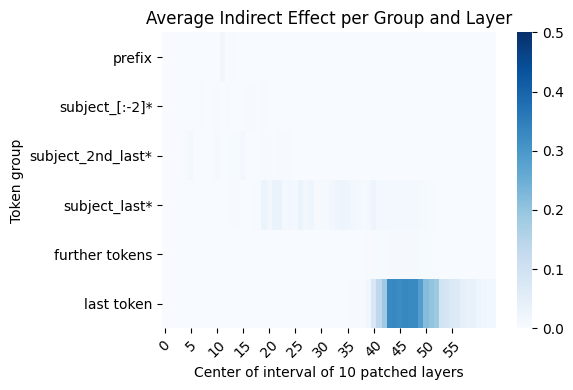

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


group_to_row = {g: i for i, g in enumerate(group_names)}

# Determine shape
max_layer = max(layer for _, layer, _, _ in avg_group_scores)
num_layers = max_layer + 1
num_groups = len(group_names)

# Create and populate heatmap
heatmap = np.full((num_groups, num_layers), np.nan)
for group, layer, label, avg_score in avg_group_scores:
    row = group_to_row[group]
    heatmap[row, layer] = avg_score

plt.figure(figsize=(6, 4))
ax = sns.heatmap(
    heatmap,
    cmap="Blues",
    xticklabels=False,  # we'll manually set them
    yticklabels=False,  # same for y-axis
    vmin=0.0,
    vmax=0.5
)

# X-axis: one tick every 5 intervals (each interval = 10 layers)
x_range = heatmap.shape[1]
xticks = [0.5 + i for i in range(0, x_range-5, 5)]
xtick_labels = [5*(i//5) for i in range(0, x_range-5, 5)]  # center of 10-layer intervals

ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=45)

# Y-axis: center the tick at each row
yticks = [0.5 + i for i in range(len(group_names))]
ytick_labels = group_names

ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)

ax.set_xlabel("Center of interval of 10 patched layers")
ax.set_ylabel("Token group")
ax.set_title("Average Indirect Effect per Group and Layer")
plt.tight_layout()
plt.show()

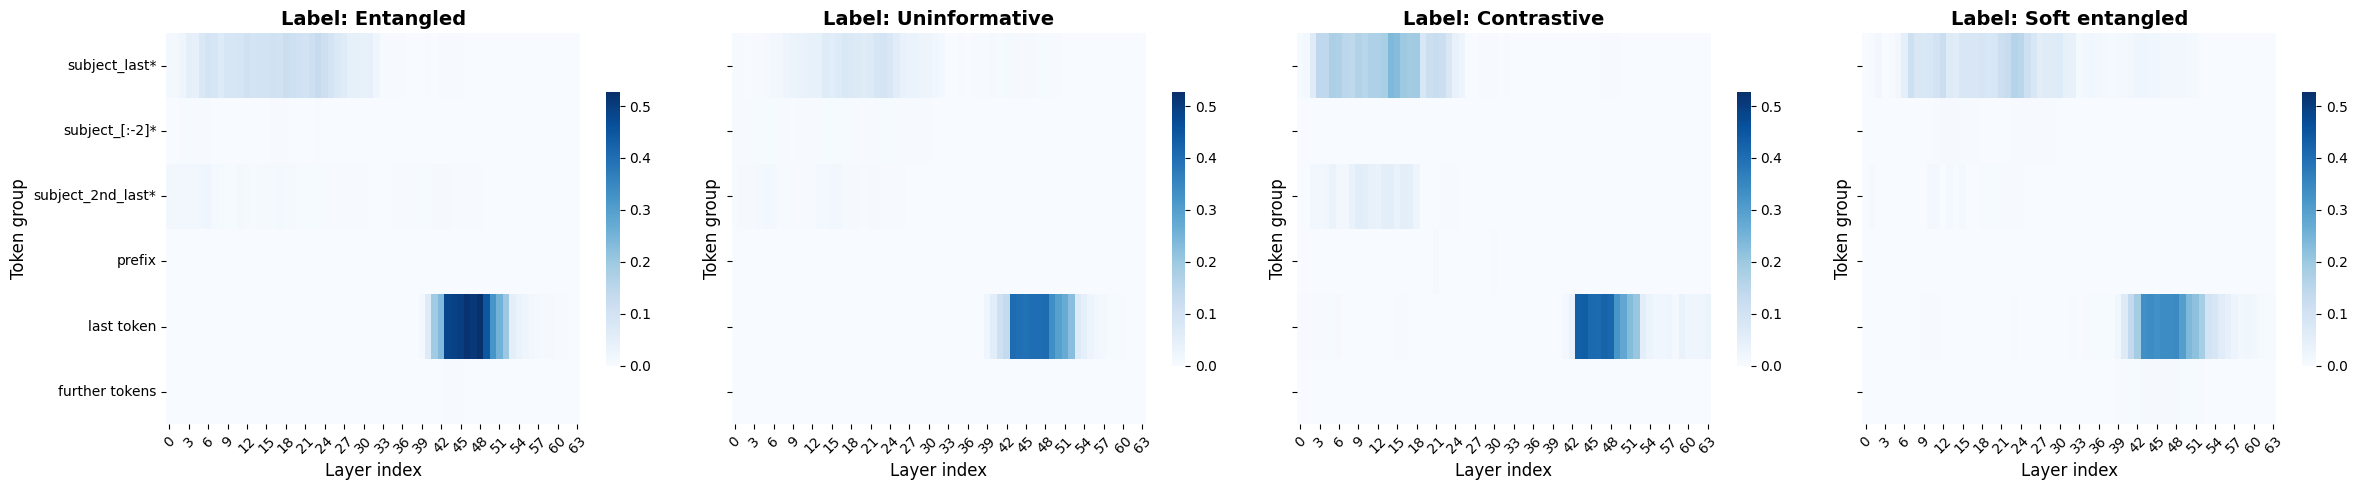

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



# Convert to DataFrame
df = pd.DataFrame(avg_group_scores, columns=["group", "layer", "label", "score"])

# Get all unique labels
unique_labels = df["label"].unique()

# Set up subplots
n_labels = len(unique_labels)
fig, axes = plt.subplots(nrows=1, ncols=n_labels, figsize=(6 * n_labels, 5), sharey=True)

# Ensure axes is iterable
if n_labels == 1:
    axes = [axes]

# Sort groups for consistent Y-axis
group_order = sorted(df["group"].unique(), reverse=True)

for ax, label in zip(axes, unique_labels):
    label_df = df[df["label"] == label]
    pivoted = label_df.pivot(index="group", columns="layer", values="score").reindex(group_order)

    sns.heatmap(
        pivoted,
        ax=ax,
        cmap="Blues",
        vmin=0,
        vmax=df["score"].max(),
        cbar=True,
        cbar_kws={"shrink": 0.7},
    )

    ax.set_title(f"Label: {label}", fontsize=14, fontweight="bold")
    ax.set_xlabel("Layer index", fontsize=12)
    ax.set_ylabel("Token group", fontsize=12)
    ax.tick_params(axis='x', labelrotation=45)
    ax.tick_params(axis='y', labelsize=10)

plt.tight_layout(w_pad=2.5)
plt.show()


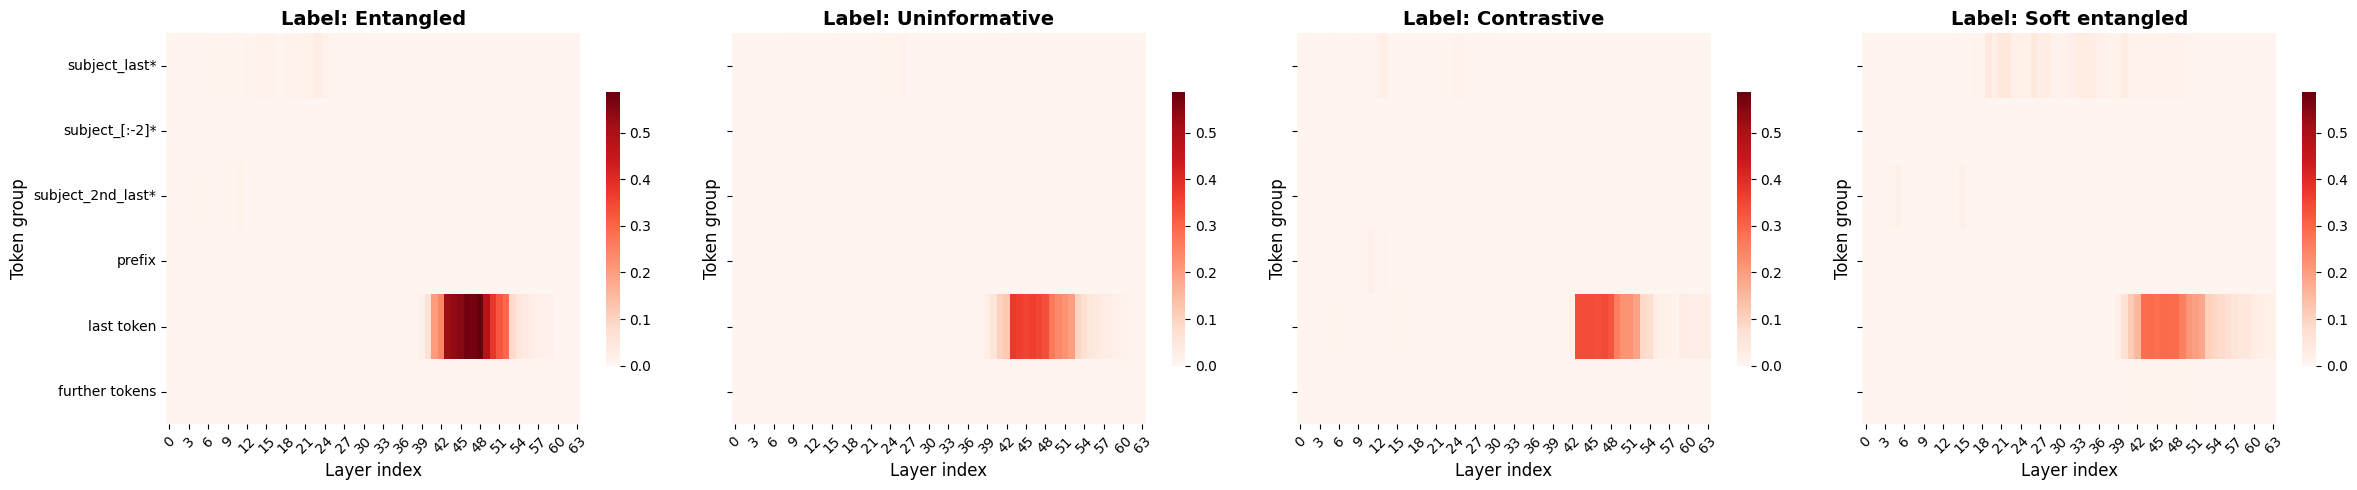

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



# Convert to DataFrame
df = pd.DataFrame(avg_group_scores, columns=["group", "layer", "label", "score"])

# Get all unique labels
unique_labels = df["label"].unique()

# Set up subplots
n_labels = len(unique_labels)
fig, axes = plt.subplots(nrows=1, ncols=n_labels, figsize=(6 * n_labels, 5), sharey=True)

# Ensure axes is iterable
if n_labels == 1:
    axes = [axes]

# Sort groups for consistent Y-axis
group_order = sorted(df["group"].unique(), reverse=True)

for ax, label in zip(axes, unique_labels):
    label_df = df[df["label"] == label]
    pivoted = label_df.pivot(index="group", columns="layer", values="score").reindex(group_order)

    sns.heatmap(
        pivoted,
        ax=ax,
        cmap="Reds",
        vmin=0,
        vmax=df["score"].max(),
        cbar=True,
        cbar_kws={"shrink": 0.7},
    )

    ax.set_title(f"Label: {label}", fontsize=14, fontweight="bold")
    ax.set_xlabel("Layer index", fontsize=12)
    ax.set_ylabel("Token group", fontsize=12)
    ax.tick_params(axis='x', labelrotation=45)
    ax.tick_params(axis='y', labelsize=10)

plt.tight_layout(w_pad=2.5)
plt.show()


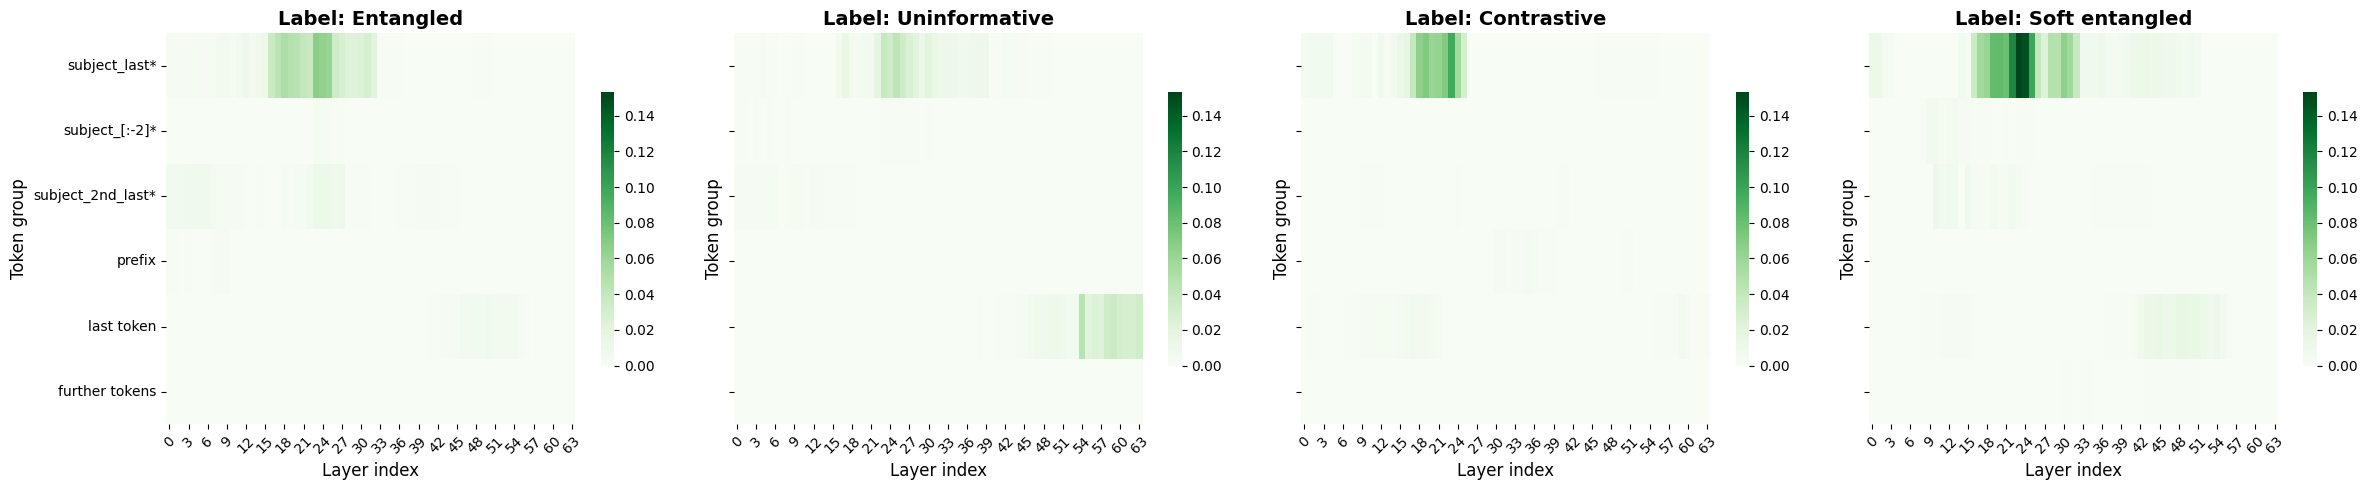

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



# Convert to DataFrame
df = pd.DataFrame(avg_group_scores, columns=["group", "layer", "label", "score"])

# Get all unique labels
unique_labels = df["label"].unique()

# Set up subplots
n_labels = len(unique_labels)
fig, axes = plt.subplots(nrows=1, ncols=n_labels, figsize=(6 * n_labels, 5), sharey=True)

# Ensure axes is iterable
if n_labels == 1:
    axes = [axes]

# Sort groups for consistent Y-axis
group_order = sorted(df["group"].unique(), reverse=True)

for ax, label in zip(axes, unique_labels):
    label_df = df[df["label"] == label]
    pivoted = label_df.pivot(index="group", columns="layer", values="score").reindex(group_order)

    sns.heatmap(
        pivoted,
        ax=ax,
        cmap="Greens",
        vmin=0,
        vmax=df["score"].max(),
        cbar=True,
        cbar_kws={"shrink": 0.7},
    )

    ax.set_title(f"Label: {label}", fontsize=14, fontweight="bold")
    ax.set_xlabel("Layer index", fontsize=12)
    ax.set_ylabel("Token group", fontsize=12)
    ax.tick_params(axis='x', labelrotation=45)
    ax.tick_params(axis='y', labelsize=10)

plt.tight_layout(w_pad=2.5)
plt.show()


In [ ]:
def get_plot(file_dir, color):
  file_paths = glob.glob(file_dir + "*.json")

  results = []

  unlabeled_data = 0
  for file_path in file_paths:

    loaded_data = json.load(open(file_path))

    loaded_data["scores"] = torch.tensor(loaded_data["scores"])
    loaded_data["low_score"] = torch.tensor(loaded_data["low_score"])
    loaded_data["high_score"] = torch.tensor(loaded_data["high_score"])


    if loaded_data['category'] == '':
      continue
    results.append(loaded_data)
  group_scores = defaultdict(list)  # key: (group, layer), value: list of IE values

  # Initialize accumulators
  group_names = ["prefix", "subject_[:-2]*", "subject_2nd_last*", "subject_last*", "further tokens", "last token"]
  group_sums = {g: [] for g in group_names}


  for result in results:
      scores = result["scores"]  # shape: [num_layers, num_tokens]
      bins = bin_token_indices(result["input_tokens"], result["subject_range"])
      scores = result['scores'] - result['low_score']

      for group, token_idxs in bins.items():
          for token_idx in token_idxs:
              for layer in range(scores.shape[1]):
                  ie = scores[token_idx, layer].item()
                  group_scores[(group, layer, result['category'])].append(ie)


  avg_group_scores = [(group, layer, label, torch.tensor(scores).mean().item()) for (group, layer, label), scores in group_scores.items()]
  import matplotlib.pyplot as plt
  import seaborn as sns
  import numpy as np


  group_to_row = {g: i for i, g in enumerate(group_names)}

  # Determine shape
  max_layer = max(layer for _, layer, _, _ in avg_group_scores)
  num_layers = max_layer + 1
  num_groups = len(group_names)

  # Create and populate heatmap
  heatmap = np.full((num_groups, num_layers), np.nan)
  for group, layer, label, avg_score in avg_group_scores:
      row = group_to_row[group]
      heatmap[row, layer] = avg_score

  plt.figure(figsize=(6, 4))
  ax = sns.heatmap(
      heatmap,
      cmap=color,
      xticklabels=False,  # we'll manually set them
      yticklabels=False,  # same for y-axis
      vmin=0.0,
      vmax=0.5
  )

  # X-axis: one tick every 5 intervals (each interval = 10 layers)
  x_range = heatmap.shape[1]
  xticks = [0.5 + i for i in range(0, x_range-5, 5)]
  xtick_labels = [5*(i//5) for i in range(0, x_range-5, 5)]  # center of 10-layer intervals

  ax.set_xticks(xticks)
  ax.set_xticklabels(xtick_labels, rotation=45)

  # Y-axis: center the tick at each row
  yticks = [0.5 + i for i in range(len(group_names))]
  ytick_labels = group_names

  ax.set_yticks(yticks)
  ax.set_yticklabels(ytick_labels)

  ax.set_xlabel("Center of interval of 10 patched layers")
  ax.set_ylabel("Token group")
  ax.set_title("Average Indirect Effect per Group and Layer")
  plt.tight_layout()
  plt.show()


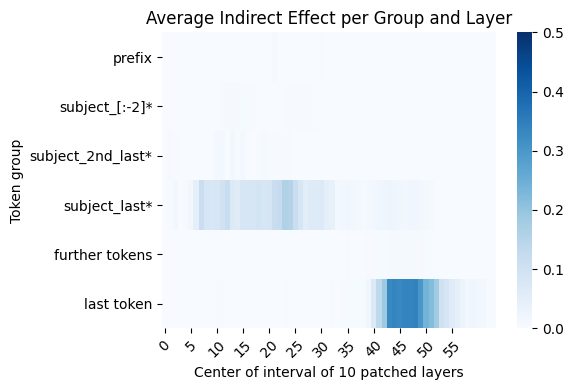

In [ ]:
get_plot( "results/after_down_proj/", "Blues")

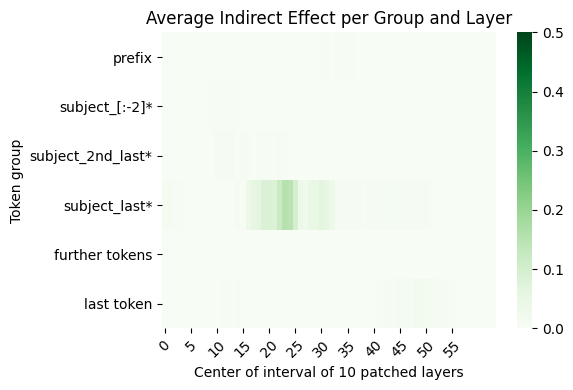

In [ ]:
get_plot( "results/mlp_after_silu/", "Greens")

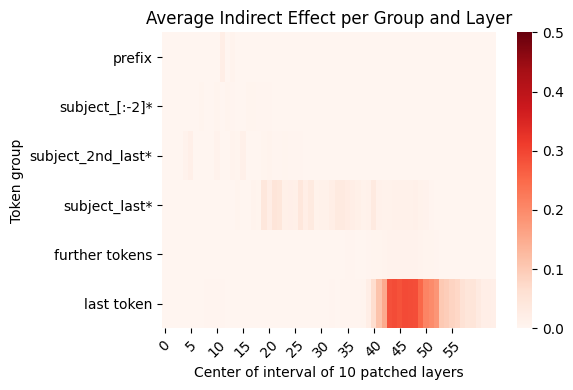

In [ ]:
get_plot( "results/ssm_after_ssm/", "Reds")

In [14]:
import glob
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def get_three_panel_plot(o_dir, g_dir, s_dir):
    def load_and_aggregate(file_dir):
        file_paths = glob.glob(file_dir + "*.json")
        group_scores = defaultdict(list)
        group_names = ["prefix", "subject_[:-2]*", "subject_2nd_last*", "subject_last*", "further tokens", "last token"]

        for file_path in file_paths:
            result = json.load(open(file_path))
            if result['category'] == "":
                continue
            result["scores"] = torch.tensor(result["scores"])
            result["low_score"] = torch.tensor(result["low_score"])
            result["high_score"] = torch.tensor(result["high_score"])
            scores = result["scores"] - result["low_score"]
            bins = bin_token_indices(result["input_tokens"], result["subject_range"])

            for group, token_idxs in bins.items():
                for token_idx in token_idxs:
                    for layer in range(scores.shape[1]):
                        group_scores[(group, layer)].append(scores[token_idx, layer].item())

        avg_group_scores = defaultdict(float)
        for (group, layer), scores in group_scores.items():
            avg_group_scores[(group, layer)] = torch.tensor(scores).mean().item()
        return avg_group_scores

    def build_heatmap(avg_group_scores, group_names, num_layers):
        group_to_row = {g: i for i, g in enumerate(group_names)}
        heatmap = np.full((len(group_names), num_layers), np.nan)
        for (group, layer), score in avg_group_scores.items():
            heatmap[group_to_row[group], layer] = score
        return heatmap

    # ---- Load data
    group_names = ["prefix", "subject_[:-2]*", "subject_2nd_last*", "subject_last*", "further tokens", "last token"]
    avg_o = load_and_aggregate(o_dir)
    avg_g = load_and_aggregate(g_dir)
    avg_s = load_and_aggregate(s_dir)
    num_layers = max(max(layer for _, layer in avg_o.keys()),
                     max(layer for _, layer in avg_g.keys()),
                     max(layer for _, layer in avg_s.keys())) + 1

    heatmap_o = build_heatmap(avg_o, group_names, num_layers)
    heatmap_g = build_heatmap(avg_g, group_names, num_layers)
    heatmap_s = build_heatmap(avg_s, group_names, num_layers)

    # ---- Plot
    fig, axes = plt.subplots(1, 3, figsize=(14, 4), dpi=150)
    cmaps = ['Blues', 'Greens', 'Reds']
    heatmaps = [heatmap_o, heatmap_g, heatmap_s]
    titles = [
        r"(a) Average IE of restoring $o_i^{(\ell)}$ on 100 facts",
        r"(b) Average IE of restoring $g_i^{(\ell)}$",
        r"(c) Average IE of restoring $s_i^{(\ell)}$"
    ]

    for ax, heatmap, cmap, title in zip(axes, heatmaps, cmaps, titles):
        sns.heatmap(
            heatmap,
            cmap=cmap,
            ax=ax,
            xticklabels=False,
            yticklabels=False,
            vmin=0.0,
            vmax=0.5,
            cbar=True,
            cbar_kws={"label": "IE"},
        )

        x_range = heatmap.shape[1]
        xticks = [0.5 + i for i in range(0, x_range - 5, 5)]
        xtick_labels = [5 * (i // 5) for i in range(0, x_range - 5, 5)]
        yticks = [0.5 + i for i in range(len(group_names))]

        ax.set_xticks(xticks)
        ax.set_xticklabels(xtick_labels, rotation=45)
        ax.set_yticks(yticks)
        ax.set_yticklabels(group_names if ax == axes[0] else [""] * len(group_names))
        ax.set_title(title, fontsize=10)
        ax.set_xlabel("center of interval of 10 patched layers")
        if ax == axes[0]:
            ax.set_ylabel("Token group")

    plt.tight_layout()
    plt.show()


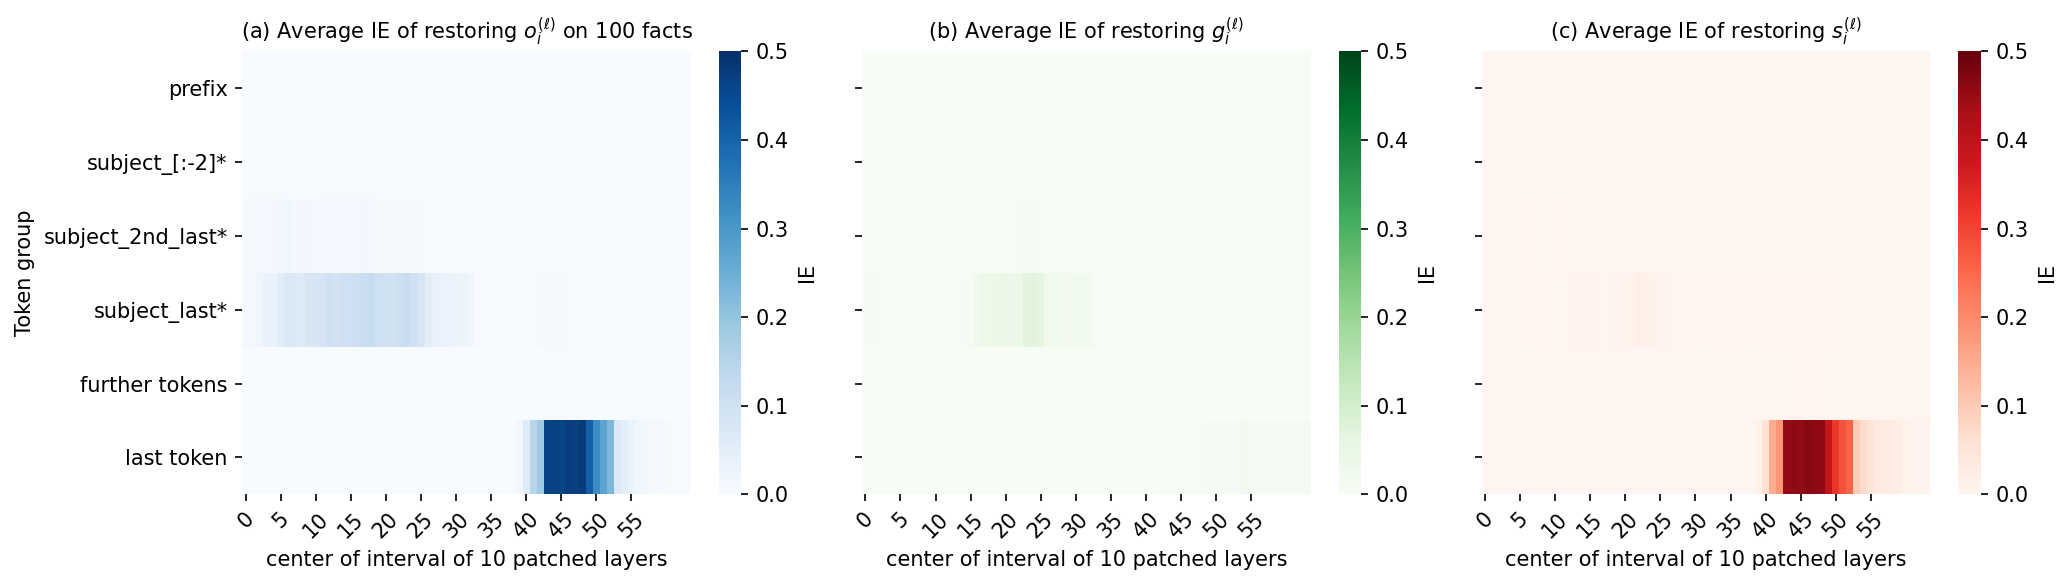

In [15]:
get_three_panel_plot("results/after_down_proj/", "results/mlp_after_silu/", "results/ssm_after_ssm/")

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_per_category_heatmaps(file_dir, cmap="Greens"):

    file_paths = glob.glob(file_dir + "*.json")

    results = []

    unlabeled_data = 0
    for file_path in file_paths:

      loaded_data = json.load(open(file_path))

      loaded_data["scores"] = torch.tensor(loaded_data["scores"])
      loaded_data["low_score"] = torch.tensor(loaded_data["low_score"])
      loaded_data["high_score"] = torch.tensor(loaded_data["high_score"])


      if loaded_data['category'] == '':
        continue
      results.append(loaded_data)
    group_scores = defaultdict(list)  # key: (group, layer), value: list of IE values

    # Initialize accumulators
    group_names = ["prefix", "subject_[:-2]*", "subject_2nd_last*", "subject_last*", "further tokens", "last token"]
    group_sums = {g: [] for g in group_names}


    for result in results:
        scores = result["scores"]  # shape: [num_layers, num_tokens]
        bins = bin_token_indices(result["input_tokens"], result["subject_range"])
        scores = result['scores'] - result['low_score']

        for group, token_idxs in bins.items():
            for token_idx in token_idxs:
                for layer in range(scores.shape[1]):
                    ie = scores[token_idx, layer].item()
                    group_scores[(group, layer, result['category'])].append(ie)


    avg_group_scores = [(group, layer, label, torch.tensor(scores).mean().item()) for (group, layer, label), scores in group_scores.items()]
    # Convert to DataFrame
    df = pd.DataFrame(avg_group_scores, columns=["group", "layer", "label", "score"])
    unique_labels = sorted(df["label"].unique())
    group_order = ["prefix", "subject_[:-2]*", "subject_2nd_last*", "subject_last*", "further tokens", "last token"]

    n_labels = len(unique_labels)
    fig, axes = plt.subplots(1, n_labels, figsize=(5.2 * n_labels, 4.5), sharey=True, dpi=150)

    if n_labels == 1:
        axes = [axes]

    vmax = 0.5
    vmin = 0.0

    for i, (ax, label) in enumerate(zip(axes, unique_labels)):
        label_df = df[df["label"] == label]
        pivoted = (
            label_df.pivot(index="group", columns="layer", values="score")
            .reindex(index=group_order)
            .fillna(0)
        )

        sns.heatmap(
            pivoted,
            ax=ax,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            cbar=True,
            cbar_kws={"label": "IE"},
            xticklabels=False,  # We'll set manually
            yticklabels=(i == 0),  # Only show on leftmost subplot
        )

        # X ticks: one every 5 layers (i.e., centered every 10 patched layers)
        x_range = pivoted.shape[1]
        xticks = list(range(0, x_range, 5))
        xtick_labels = [str(i) for i in xticks]
        ax.set_xticks([i + 0.5 for i in xticks])
        ax.set_xticklabels(xtick_labels, rotation=45)

        yticks = [i + 0.5 for i in range(len(group_order))]
        ax.set_yticks(yticks)
        ax.set_yticklabels(group_order if i == 0 else [""] * len(group_order))



        ax.set_title(f"Label: {label}", fontsize=13, fontweight="bold")
        ax.set_xlabel("center of interval of 10 patched layers", fontsize=11)
        if i == 0:
            ax.set_ylabel("Token group", fontsize=11)
        else:
            ax.set_ylabel("")

        ax.tick_params(axis='y', labelsize=10)

    plt.tight_layout(w_pad=2.5)
    plt.show()


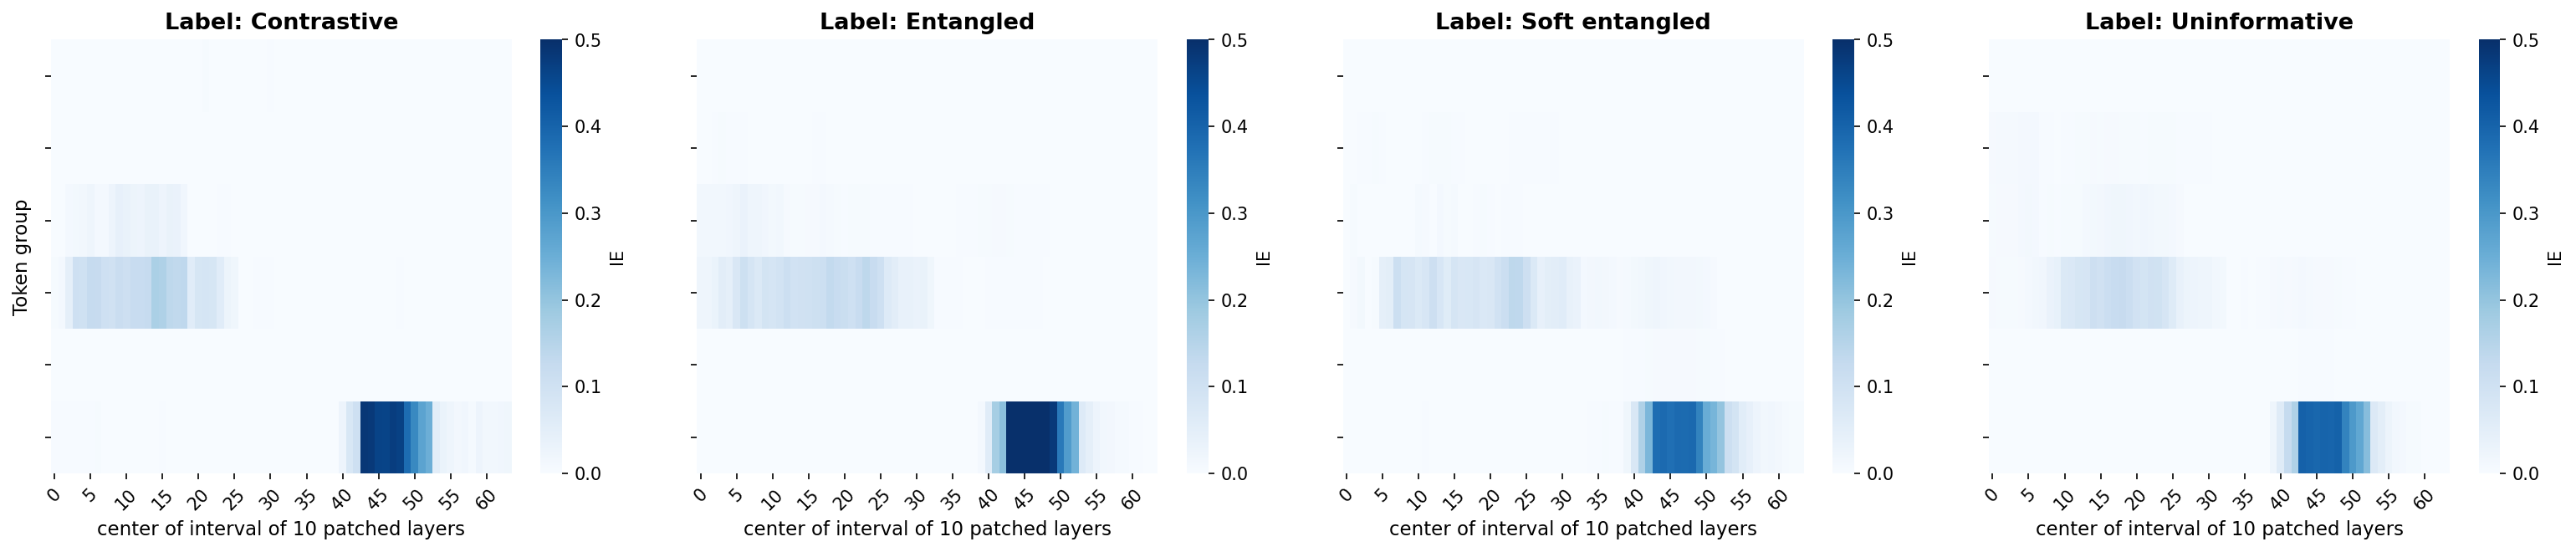

In [11]:
plot_per_category_heatmaps("results/after_down_proj/", cmap="Blues")

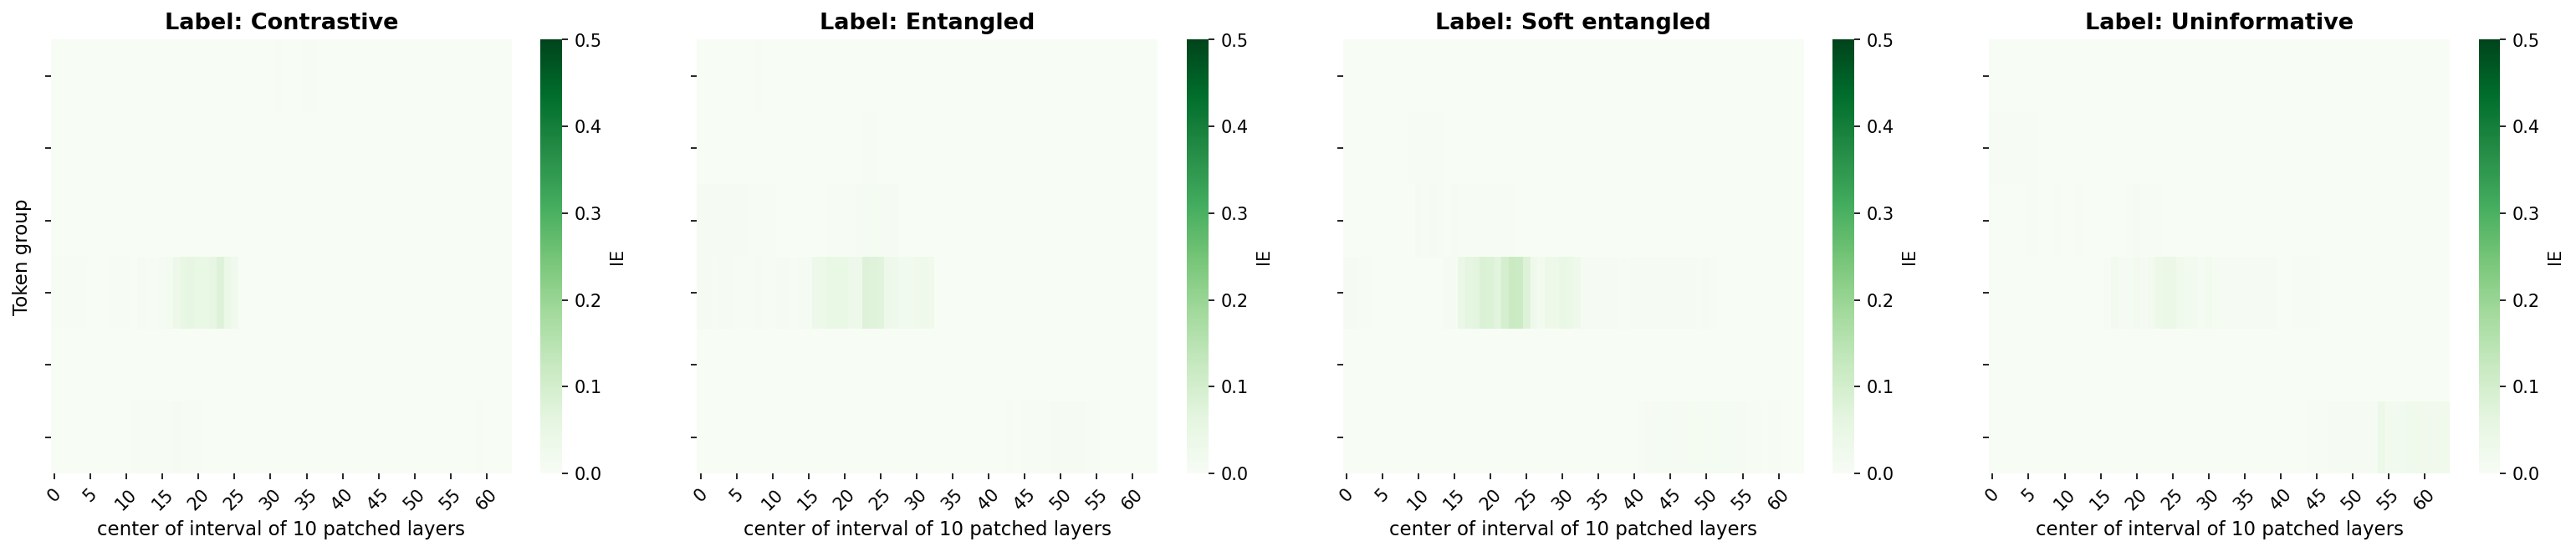

In [12]:
plot_per_category_heatmaps("results/mlp_after_silu/", cmap="Greens")

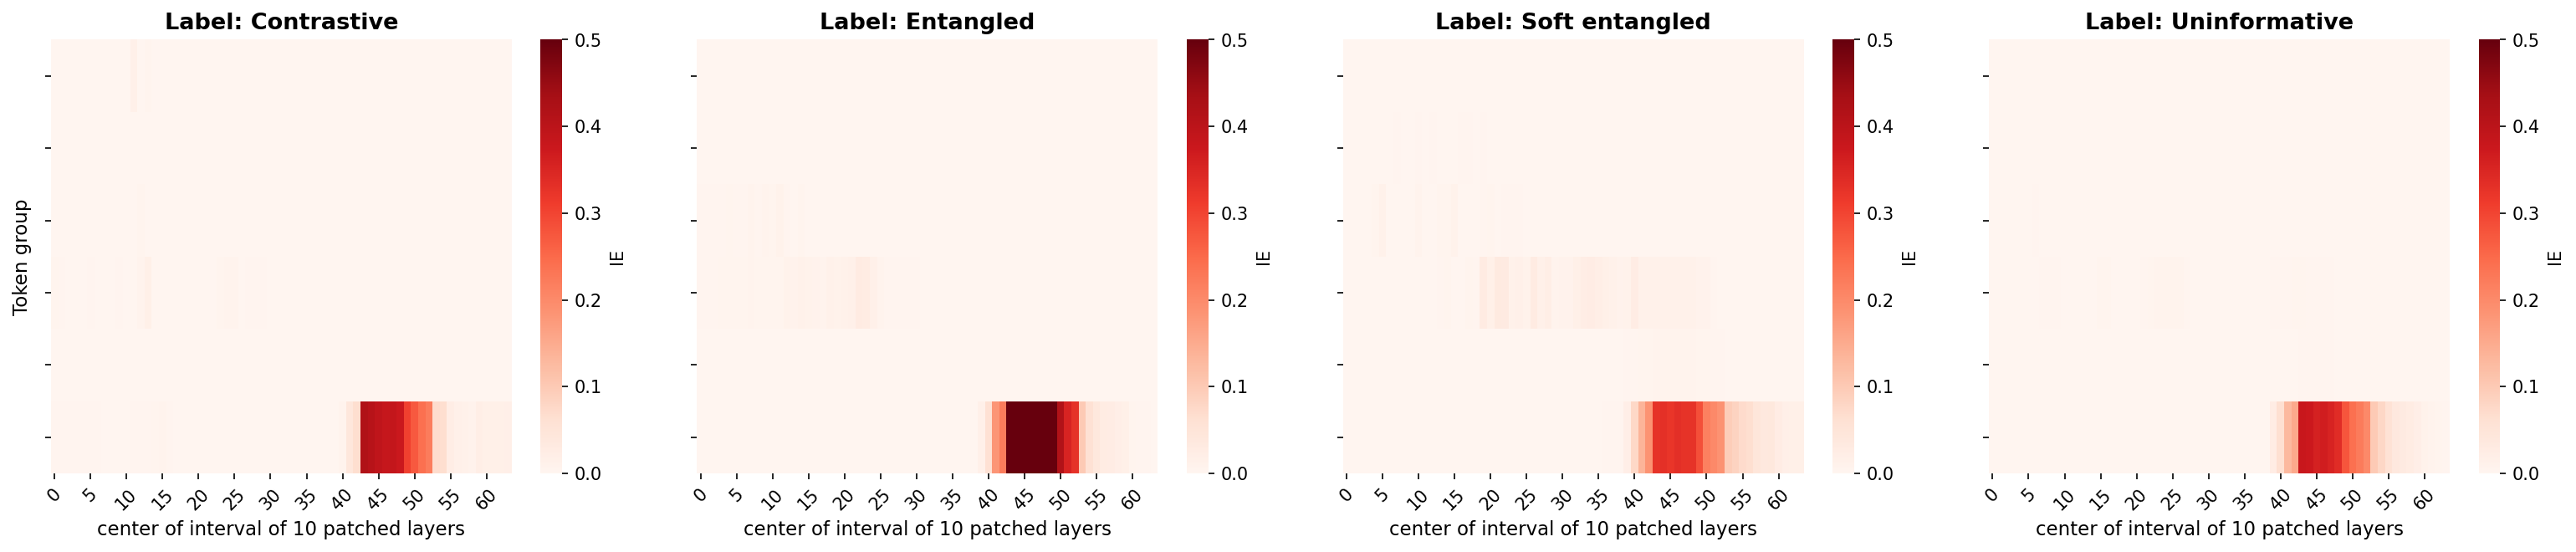

In [13]:
plot_per_category_heatmaps("results/ssm_after_ssm/", cmap="Reds")